In [ ]:
#| default_exp utils

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# Utils

> Utilities used in the rest of the notebooks

In [8]:
#| export
from dvats.imports import *
from fastcore.all import *
import wandb
import pickle
import pandas as pd
import numpy as np
#import tensorflow as tf
import torch.nn as nn
from fastai.basics import *

### Generate random time series dataframe

In [ ]:
#| export
def generate_TS_df(rows, cols):
    "Generates a dataframe containing a multivariate time series, where each column \
    represents a variable and each row a time point (sample). The timestamp is in the \
    index of the dataframe, and it is created with a even space of 1 second between samples"
    index = np.arange(pd.Timestamp.now(),
                      pd.Timestamp.now() + pd.Timedelta(rows-1, 'seconds'),
                      pd.Timedelta(1, 'seconds'))
    data = np.random.randn(len(index), cols)
    return pd.DataFrame(data, index=index)

In [ ]:
#| hide
df = generate_TS_df(3, 5)

In [ ]:
#| hide
test_eq(df.shape, (3, 5))

##  pandas Dataframe utilities

### Normalize columns

In [ ]:
#| export
def normalize_columns(df:pd.DataFrame):
    "Normalize columns from `df` to have 0 mean and 1 standard deviation"
    mean = df.mean()
    std = df.std() + 1e-7
    return (df-mean)/std

In [ ]:
#| hide
foo = generate_TS_df(3, 3)
foo.describe()

,0,1,2
count,3.000000,3.000000,3.000000
mean,0.815116,-0.509695,0.080586
std,0.267142,0.326170,1.210821
min,0.562261,-0.779326,-1.045160
25%,0.675396,-0.690968,-0.559881
50%,0.788531,-0.602610,-0.074601
75%,0.941544,-0.374880,0.643458
max,1.094556,-0.147149,1.361518


In [ ]:
#| hide
bar = normalize_columns(foo)
bar.describe()

,0,1,2
count,3.000000e+00,3.000000e+00,3.000000e+00
mean,-2.914335e-16,-1.295260e-16,3.700743e-17
std,9.999996e-01,9.999997e-01,9.999999e-01
min,-9.465212e-01,-8.266579e-01,-9.297374e-01
25%,-5.230184e-01,-5.557622e-01,-5.289521e-01
50%,-9.951559e-02,-2.848665e-01,-1.281669e-01
75%,4.732606e-01,4.133290e-01,4.648687e-01
max,1.046037e+00,1.111524e+00,1.057904e+00


In [ ]:
#| hide
test_close(bar.describe().loc['mean'].values, np.repeat(0.0, len(bar.columns)))

In [ ]:
#| hide
test_close(bar.describe().loc['std'].values, np.repeat(1.0, len(bar.columns)))

### Remove constant columns

In [ ]:
#| export
def remove_constant_columns(df:pd.DataFrame):
    return df.loc[:, (df != df.iloc[0]).any()]

In [ ]:
#| hide
foo = generate_TS_df(3, 3)
foo['constant'] = [0.0]*len(foo)
foo

,0,1,2,constant
2024-04-03 09:17:26.823260,1.007134,0.195662,0.347108,0.0
2024-04-03 09:17:27.823260,0.190472,-0.721032,-1.919413,0.0
2024-04-03 09:17:28.823260,0.667243,0.308052,0.645084,0.0


In [ ]:
#| hide
bar = remove_constant_columns(foo)
bar

,0,1,2
2024-04-03 09:17:26.823260,1.007134,0.195662,0.347108
2024-04-03 09:17:27.823260,0.190472,-0.721032,-1.919413
2024-04-03 09:17:28.823260,0.667243,0.308052,0.645084


In [ ]:
#| hide
column_diff = set(foo.columns) - set(bar.columns)
test_eq_type(column_diff, set(['constant']))

## Create wandb artifact containing just the reference to an object pass as argument

In [ ]:
#| export
class ReferenceArtifact(wandb.Artifact):
    default_storage_path = Path('data/wandb_artifacts/') # * this path is relative to Path.home()
    "This class is meant to create an artifact with a single reference to an object \
    passed as argument in the contructor. The object will be pickled, hashed and stored \
    in a specified folder."
    @delegates(wandb.Artifact.__init__)
    def __init__(self, obj, name, type='object', folder=None, **kwargs):
        super().__init__(type=type, name=name, **kwargs)
        # pickle dumps the object and then hash it
        hash_code = str(hash(pickle.dumps(obj)))
        folder = Path(ifnone(folder, Path.home()/self.default_storage_path))
        with open(f'{folder}/{hash_code}', 'wb') as f:
            pickle.dump(obj, f)
        self.add_reference(f'file://{folder}/{hash_code}')
        if self.metadata is None:
            self.metadata = dict()
        self.metadata['ref'] = dict()
        self.metadata['ref']['hash'] = hash_code
        self.metadata['ref']['type'] = str(obj.__class__)

In [ ]:
#| hide
foo = np.arange(10)
bar = ReferenceArtifact(obj=foo, name='foo', folder='.')
bar_path = Path(f'./{bar.metadata["ref"]["hash"]}')
test_eq(bar_path.exists(), True)
test_eq(bar.metadata['ref']['type'], "<class 'numpy.ndarray'>")

ValueError: Path "file://./-1885988180256686673" must be a valid file or directory path

When a reference artifact is used by one wandb run, we should have a method to get the original object from it

In [ ]:
#| export
@patch
def to_obj(self:wandb.apis.public.Artifact):
    """Download the files of a saved ReferenceArtifact and get the referenced object. The artifact must \
    come from a call to `run.use_artifact` with a proper wandb run."""
    if self.metadata.get('ref') is None:
        print(f'ERROR:{self} does not come from a saved ReferenceArtifact')
        return None
    original_path = ReferenceArtifact.default_storage_path/self.metadata['ref']['hash']
    path = original_path if original_path.exists() else Path(self.download()).ls()[0]
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

Test with Reference artifact from a df

In [ ]:
#| hide
foo = generate_TS_df(3, 3)
bar = ReferenceArtifact(obj=foo, name='test_reference_artifact')
bar.manifest.entries.values()

dict_values([ArtifactManifestEntry(path='-8871448523836712233', digest='mwF1UtZ6D7+U+iNMWFuf4A==', ref='file:///home/macu/data/wandb_artifacts/-8871448523836712233', birth_artifact_id=None, size=1005, extra={}, local_path=None)])

In [ ]:
#| hide
test_eq(bar.name, 'test_reference_artifact')

In [ ]:
#| hide
test_eq(bar.metadata['ref']['type'], str(type(foo)))

TODO: Test method `to_obj`

ReferenceArtifact with a numpy array

In [ ]:
#| hide
foo = np.random.randn(5)
bar = ReferenceArtifact(obj=foo, name='test_reference_artifact')
bar.manifest.entries.values()

dict_values([ArtifactManifestEntry(path='4465931929537276473', digest='Bi6mPdsaC/6HyHjPVmI7PQ==', ref='file:///home/macu/data/wandb_artifacts/4465931929537276473', birth_artifact_id=None, size=187, extra={}, local_path=None)])

In [ ]:
#| hide
test_eq(bar.metadata['ref']['type'], str(type(foo)))

In [ ]:
#| export
import torch.nn as nn
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()

    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

In [ ]:
#| export
@patch
def export_and_get(self:Learner, keep_exported_file=False):
    """
        Export the learner into an auxiliary file, load it and return it back.
    """
    aux_path = Path('aux.pkl')
    self.export(fname='aux.pkl')
    aux_learn = load_learner('aux.pkl')
    if not keep_exported_file: aux_path.unlink()
    return aux_learn

### get_wandb_artifacts

In [ ]:
#| export
def get_wandb_artifacts(project_path, type=None, name=None, last_version=True):
    """
        Get the artifacts logged in a wandb project.
        Input:
        - `project_path` (str): entity/project_name
        - `type` (str): whether to return only one type of artifacts
        - `name` (str): Leave none to have all artifact names
        - `last_version`: whether to return only the last version of each artifact or not

        Output: List of artifacts
    """
    public_api = wandb.Api()
    if type is not None:
        types = [public_api.artifact_type(type, project_path)]
    else:
        types = public_api.artifact_types(project_path)

    res = L()
    for kind in types:
        for collection in kind.collections():
            if name is None or name == collection.name:
                versions = public_api.artifact_versions(
                    kind.type,
                    "/".join([kind.entity, kind.project, collection.name]),
                    per_page=1,
                )
                if last_version: res += next(versions)
                else: res += L(versions)
    return list(res)

In [ ]:
#| hide
foo = get_wandb_artifacts('wandb/artifacts-example', type='model')
test_eq(len(foo), 2)
foo = get_wandb_artifacts('wandb/artifacts-example', type='model', name='convnet')
test_eq(len(foo), 1)
foo = get_wandb_artifacts('wandb/artifacts-example', type='model', name='convnet', last_version=False)
test_eq(len(foo), 2)

AssertionError: ==:
3
2

### get_pickle_artifact

In [ ]:
#| export
def get_pickle_artifact(filename):

    with open(filename, "rb") as f:
        df = pickle.load(f)
    
    return df

## Exec from feather

In [ ]:
#| export
import pyarrow.feather as ft
import pickle

In [ ]:
#| export
def exec_with_feather(function, path = None, print_flag = False, *args, **kwargs):
    result = None
    if not (path is none):
        if print_flag: print("--> Exec with feather | reading input from ", path)
        input = ft.read_feather(path)
        if print_flag: print("--> Exec with feather | Apply function ", path)
        result = function(input, *args, **kwargs)
        if print_flag: print("Exec with feather --> ", path)
    return result

In [ ]:
#| export
def py_function(module_name, function_name, print_flag = False):
    try:
        function = getattr(__import__('__main__'), function_name)
    except:
        module = __import__(module_name, fromlist=[''])
        function = getattr(module, function_name)
    print("py function: ", function_name, ": ", function)
    return function

In [ ]:
#| hide
def suma(a,b,c): return a+b+c
foo = py_function("main", "suma", True)
print(foo(1,1,1))

py function:  suma :  <function suma>
3


In [ ]:
#| hide
function_name = "prepare_forecasting_data"
module_name = "tsai.data.preparation"
foo = py_function(module_name, function_name, True)
foo

py function:  prepare_forecasting_data :  <function prepare_forecasting_data>


<function tsai.data.preparation.prepare_forecasting_data(df: 'pd.DataFrame', fcst_history: 'int', fcst_horizon: 'int' = 1, x_vars: 'str | list' = None, y_vars: 'str | list' = None, dtype: 'str' = None, unique_id_cols: 'str | list' = None) -> 'tuple(np.ndarray, np.ndarray)'>

In [ ]:
#| export
import time
def exec_with_feather_k_output(function_name, module_name = "main", path = None, k_output = 0, print_flag = False, time_flag = False, *args, **kwargs):
    result = None
    function = py_function(module_name, function_name, print_flag)
    if time_flag: t_start = time.time()
    if not (path is None):
        if print_flag: print("--> Exec with feather | reading input from ", path)
        input = ft.read_feather(path)
        if print_flag: print("--> Exec with feather | Apply function ", path)
        result = function(input, *args, **kwargs)[k_output]
    if time_flag:
        t_end = time.time()
        print("Exec with feather | time: ", t_end-t_start)
    if print_flag: print("Exec with feather --> ", path)
    return result

In [ ]:
#| hide
enc_input = exec_with_feather_k_output(
            function_name = "prepare_forecasting_data",
            module_name   = "tsai.data.preparation",
            path = "/home/macu/data/wandb_artifacts/-2535364569820284064",
            k_output = 0,
            print_flag = True,
            time_flag = True,
            fcst_history = 450
        )
enc_input

py function:  prepare_forecasting_data :  <function prepare_forecasting_data>
--> Exec with feather | reading input from  /home/macu/data/wandb_artifacts/-2535364569820284064
--> Exec with feather | Apply function  /home/macu/data/wandb_artifacts/-2535364569820284064
Exec with feather | time:  0.40880537033081055
Exec with feather -->  /home/macu/data/wandb_artifacts/-2535364569820284064


array([[[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]]])

In [ ]:
#| export
def exec_with_and_feather_k_output(function_name, module_name = "main", path_input = None, path_output = None, k_output = 0, print_flag = False, time_flag = False, *args, **kwargs):
    result = None
    function = py_function(module_name, function_name, print_flag)
    if time_flag: t_start = time.time()
    if not (path_input is None):
        if print_flag: print("--> Exec with feather | reading input from ", path_input)
        input = ft.read_feather(path_input)
        if print_flag: 
            print("--> Exec with feather | Apply function ", function_name, "input type: ", type(input))
        
        result = function(input, *args, **kwargs)[k_output]
        ft.write_feather(df, path, compression = 'lz4')
    if time_flag:
        t_end = time.time()
        print("Exec with feather | time: ", t_end-t_start)
    if print_flag: print("Exec with feather --> ", path_output)
    return path_output

## Time handling

In [ ]:
#| export 
import time
from dataclasses import dataclass, field

In [ ]:
#| export
@dataclass
class Time:
    time_start  : float =  None
    time_end    : float =  None
    time_total  : float =  0.0
    function    : str   =  ''

    def start(self, print_flag = False): 
        if print_flag: print("--> Start: ", self.function)
        self.time_start = time.time()
        return self.time_start

    def end(self, print_flag = False):
        self.time_end = time.time()
        self.time_total = self.duration()
        if print_flag: print("End: ", self.function, "-->")
        return self.time_end
        
    def duration(self):
        self.time_total=self.time_end - self.time_start
        return self.time_total
    def show(self):
        if self.time_start is None: 
            print(f"[{self.function}] Not started")
        elif self.time_end is None:
            print(f"[{self.function}] Not ended | Start: ", self.time_start)
        else:
            print(f"[{self.function}] Start: {self.time_start} | End: {self.time_end} | Duration: {self.time_total} seconds")
        return self.time_total     

In [ ]:
#| export
def funcname():
    """Get calling function name"""
    return inspect.stack()[1][3]

In [ ]:
#| hide
# Timer basic example
foo = Time()
foo.start()
time.sleep(2) 
foo.end()
foo.show()
def foo(): return funcname()
foo()

[] Start: 1712136000.665826 | End: 1712136002.668165 | Duration: 2.0023388862609863 seconds


'foo'

## VSCode update path

In [ ]:
#| export
#Function for making notebooks clearer
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
    print("... Enabling Vs Code execution ...")

In [ ]:
#| hide
#from nbdev.export import notebook2script
#notebook2script()
beep(1)

# Styled printing

In [1]:
#| export
from IPython.display import display, HTML

In [2]:
#| export
def styled_print(text, color='black', size='16px', weight='normal'):
    html_text = f"<span style='color: {color}; font-size: {size}; font-weight: {weight};'>{text}</span>"
    display(HTML(html_text))

# Time Series

## Plots

In [18]:
#| export
def show_sequence(
    data         : List[ List [ float ] ] = None, 
    hide_rows    : bool = False, 
    hide_columns : bool = True
):
    """
    Show the sequence in a nice format similar to stumpy tutorials
    """
    df          = pd.DataFrame(data)
    styled_df   = df.style
    if hide_rows: 
        styled_df = styled_df.hide(axis='index')
    if hide_columns: 
        styled_df = styled_df.hide(axis='columns')
    styled_df = styled_df.set_table_styles([
        {'selector': '',
         'props': [('border', '2px solid black'),
                   ('text-align', 'center'),
                   ('font-family', 'Arial'),
                   ('border-collapse', 'collapse')]},
        {'selector': 'td',
         'props': [('border', '1px solid black'),
                   ('padding', '5px')]}
    ])
    display(styled_df)

In [19]:
#| export
def plot_with_dots(
    time_series             : List[float]    = None,
    xlabel                  : str            = 'Index (time)',
    ylabel                  : str            = 'Value',
    title                   : str            = 'Time series',
    sequence_flag           : bool           = True,
    show_sequence_before    : bool           = True, 
    hide_rows               : bool           = True,
    hide_columns            : bool           = False,
    show_title              : bool           = True,
    fontsize                : int            = 10,
    save_plot               : bool           = False,
    dots                    : bool           = True,
    figsize                 : Tuple[int, int]= (10, 6),
    plot_path               : str            = "./",
    plot_name               : str            = ""
  ) -> None:
    if sequence_flag and show_sequence_before: 
        show_sequence([time_series], hide_rows, hide_columns)
    n = len(time_series)
    x_coords = range(n)
    
    plt.figure(figsize=figsize)  # Crear la figura con el tamaño especificado
    
    if dots: 
        plt.plot(x_coords, time_series)
        plt.scatter(x_coords, time_series, color='red')
    else:
        plt.plot(x_coords, time_series, linestyle='-')
        
    if show_title: 
        plt.title(title, fontsize=fontsize)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if save_plot:
        plot_path = os.path.expanduser(plot_path)
        if plot_name == "":
            plot_name = title
        plot_path = os.path.join(plot_path, plot_name + ".png")
        plt.savefig(plot_path)
    plt.show()
    if sequence_flag and not show_sequence_before:
        show_sequence([time_series], hide_rows, hide_columns)
    return None


0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,3,2,9,1,14,15,1,2,2,10,7


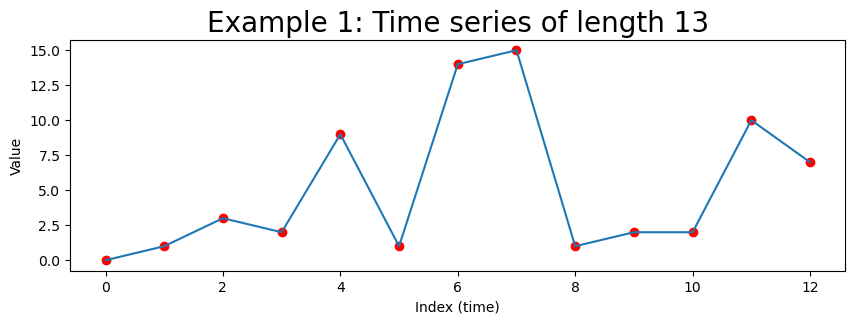

In [20]:
#| hide
# Example following Stumpy's 13-length case
plt.close('all')
foo_data = np.array([0, 1, 3, 2, 9, 1, 14, 15, 1, 2, 2, 10, 7])
foo_title = title = "Example 1: Time series of length 13"
show_sequence([foo_data], hide_rows = True, hide_columns = False)
plot_with_dots(
    time_series             = foo_data,
    title                   = foo_title,
    sequence_flag           = False,
    fontsize                = 20,
    figsize                 = (10,3)
) 

## Downsampling

### Piecewise Aggregate Approximation

In [21]:
#| export
## -- Classes & types
from dataclasses import dataclass, field
from typing import List, Optional, Tuple, Callable

In [22]:
#| export
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline

In [78]:
#| export
@dataclass
class Interpolator(BaseEstimator, TransformerMixin):
    method            : str  ='linear'
    n_segments        : int  = 1
    plot_original_data: bool = False
    plot_interpolated : bool = False
    verbose           : int  = 0
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
                
        if X.ndim == 1:
            X = X.reshape(1, -1)
        
        if self.plot_original_data:
            if self.print_flag: print("Interpolator | Plot original data")
            for dim in range (X.ndim-1):
                if self.print_flag: print(f"Interpolator | Plot original data dimension {dim}")
                plot_with_dots(
                    X[dim], 
                    sequence_flag = False, 
                    title = f'Original data | dim {dim}'
                )
                
        n_samples, n_features = X.shape
        if n_features % self.n_segments != 0 or n_features == self.n_segments:
            raise ValueError(
                f"The number of segments {self.n_segments} must divide (and be different of) the number of features {n_features} | Reminder: {n_features // self.n_segments}"
            )

        segment_size = n_features // self.n_segments
        interpolated_result = np.full_like(X, np.nan)

        if self.verbose > 0: print(f"NFeatures: {n_features} | NSegments: {self.n_segments} | segment_size: {segment_size} | interpolated result ~ {interpolated_result.shape}")
        
        for i in np.arange(self.n_segments):
            start = i * segment_size 
            end = start + segment_size
            segment_mean = np.nanmean(X[:, start:end], axis=1)
            for j in np.arange(n_samples):
                nan_mask = np.isnan(X[j, start:end])
                interpolated_result[j, start:end][nan_mask] = segment_mean[j]
        res = np.where(np.isnan(X), interpolated_result, X)
        if self.plot_interpolated:
            for dim in range (X.ndim-1):
                plot_with_dots(
                    res[dim], 
                    sequence_flag = False, 
                    title = f'Interpolated data | dim {dim}'
                )
            
        return res

NFeatures: 8 | NSegments: 4 | segment_size: 2 | interpolated result ~ (1, 8)


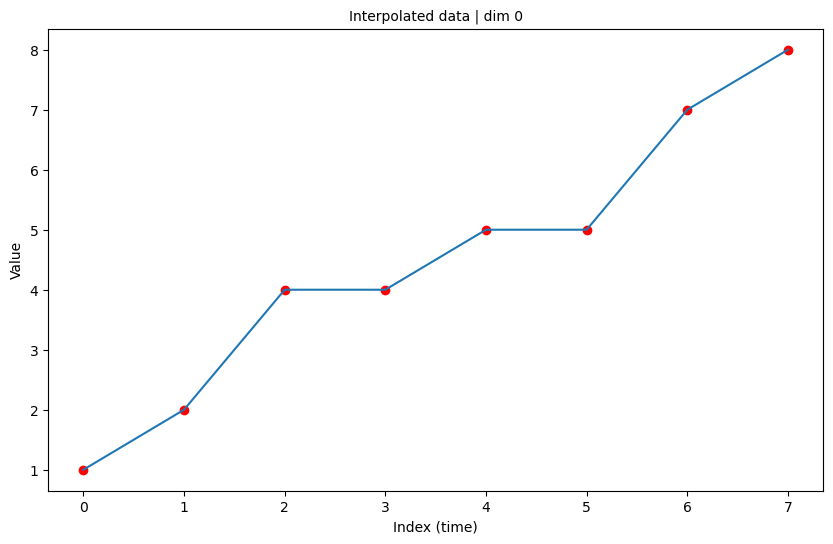

In [80]:
foo_data = np.array([1.0, 2.0, np.nan, 4.0, 5.0, np.nan, 7.0, 8.0])

foo_inter = Interpolator(
            method='polynomial', 
            n_segments         = 4,
            plot_interpolated  = True,
            plot_original_data = False,
            verbose            = 2
        )

foo = foo_inter.fit_transform(foo_data)[0]

In [81]:
#| export
@dataclass
class PAATransformer(BaseEstimator, TransformerMixin):
    n_segments       : int  = 1
    plot_aggregated  : bool = True
    verbose          : int  = 0

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        n_samples, n_features = X.shape
        if n_features <= self.n_segments:
            raise ValueError(f"The number of segments ({self.n_segments}) must be lower than the number of points ({n_features})")

        segment_size = n_features // ( self.n_segments + 1)
        remainder = n_features % ( self.n_segments + 1)

        if self.verbose > 0: 
            print(f"NFeatures: {n_features} | NSegments: {self.n_segments} | Segment size: {segment_size} | Reminder: {remainder}")

        # Crear un array para los resultados
        result = np.zeros((n_samples, self.n_segments + 1))

        if self.verbose > 1: print(f"Result ~ {result.shape}")

        # Procesar cada segmento
        for i in range(self.n_segments+1):
            start = i * segment_size + min(i, remainder)
            end = start + segment_size + (1 if i < remainder else 0)
            result[:, i] = np.mean(X[:, start:end], axis=1)

        if self.plot_aggregated:
            for dim in range (X.ndim-1):
                if self.verbose > 1:
                    print("Plos res | Dim", dim)
                plot_with_dots(
                    result[dim], 
                    sequence_flag = False, 
                    title = f'Aggregated data | dim {dim}',
                    fontsize = 20,
                    save_plot = True
                )

        return result


NFeatures: 8 | NSegments: 4 | segment_size: 2 | interpolated result ~ (1, 8)


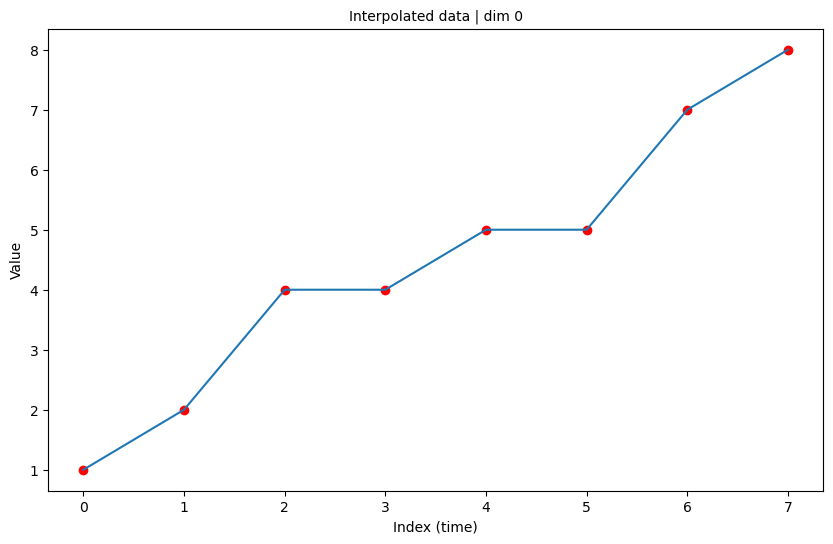

NFeatures: 8 | NSegments: 3 | Segment size: 2 | Reminder: 0
Result ~ (1, 4)
Plos res | Dim 0


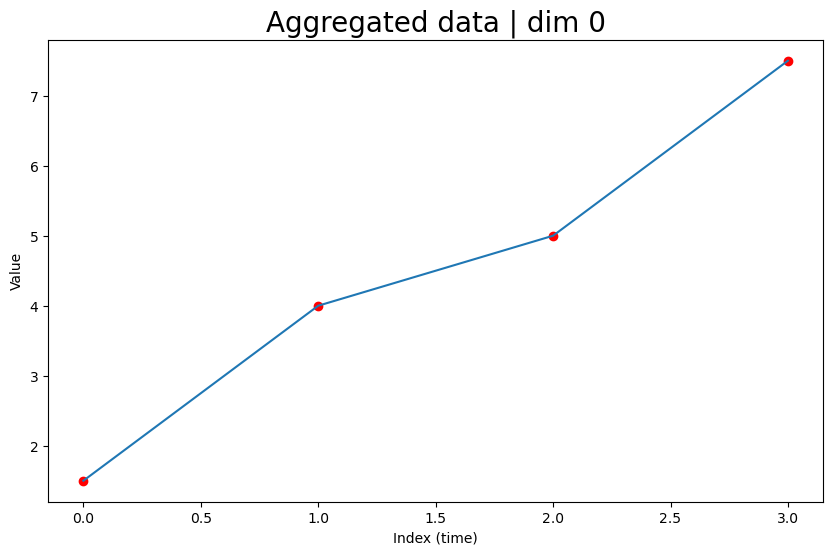

In [83]:
#| hide
foo_data = np.array([1.0, 2.0, np.nan, 4.0, 5.0, np.nan, 7.0, 8.0])
foo_paa_pipeline = Pipeline([
    (
        # Step for interpolating NaNs in the original data
        'interpolator', 
        Interpolator(
            method='polynomial', 
            n_segments         = 4, 
            plot_interpolated  = True,
            plot_original_data = False,
            verbose            = 2
        )
    ),
    (
        # Step for applying Peicewise Aggregated Approximation
        'paa', PAATransformer(
            n_segments      = 3, 
            plot_aggregated = True, 
            verbose         = 2
        )
    )
])


foo = foo_paa_pipeline.fit_transform(foo_data)[0]

In [26]:
#| export
def downsample(
    data  : List [ float ] = None,
    min_position : int  = 0,
    max_position : int  = -1, 
    max_points   : int  = 10000,
    verbose      : int  = 1,
    show_plots   : bool = False,
) -> Tuple [ List [ float ], float ]:    
    if verbose > 1: print(f"[ Downsample ] Before | Pos ({min_position}, {max_position})")
    min_position = min_position if min_position > 0 else 0
    max_position = max_position if ( max_position > -1 and max_position < len(data) ) else len(data)
    if verbose > 1: print(f"[ Downsample ] After Pos ({min_position}, {max_position})")
    n_timestamps = max_position - min_position
    paa_factor = np.maximum(1, n_timestamps // max_points)
    if verbose > 0:
        print(f"Downsample | N timestamps {n_timestamps}")
        print(f"Downsample | PAA factor: {paa_factor}")
    potential_segments = np.floor(n_timestamps / paa_factor).astype(int)
    if verbose > 1: 
        print(f"Potential segments: {potential_segments}")
    while (
                n_timestamps % potential_segments != 0 
            and potential_segments < n_timestamps
        ):
            potential_segments+=1

    n_segments = potential_segments
    if verbose > 0: print(f"Downsample | N segments: {n_segments}")

    #| export
    paa_pipeline = Pipeline([
        (
            # Step for interpolating NaNs in the original data
            'interpolator', 
            Interpolator(
                method             = 'polynomial', 
                n_segments         = n_segments, 
                plot_original_data = show_plots,
                plot_interpolated  = show_plots
            )
        ),
        (
            # Step for applying Peicewise Aggregated Approximation
            'paa', PAATransformer(
                n_segments      = n_segments, 
                plot_aggregated = show_plots
            )
        )
    ])

    ts_paa = paa_pipeline.fit_transform(data[min_position:max_position])[0]
    if verbose > 0: 
        print(f"Downsample | ts_paa~{len(ts_paa)}")
        print(f"Downsample ------------------------>")
    return ts_paa, paa_factor


Before | Pos (0, -1)
After Pos (0, 8)
------------------------> Downsample
Downsample | N timestamps 8
Downsample | PAA factor: 1
Potential segments: 8
Downsample | N segments: 8
Downsample | Final w: 1
Downsample | Reminder: 0


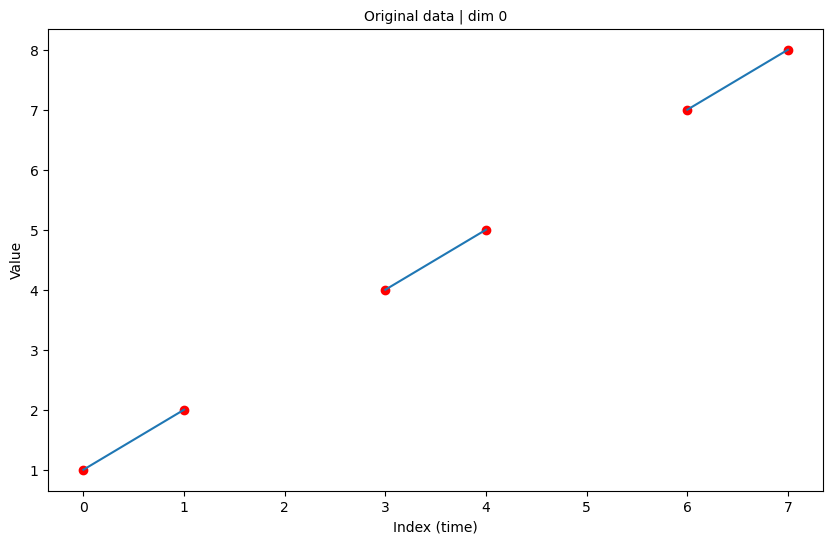

/tmp/ipykernel_9379/2524287898.py:49: RuntimeWarning: Mean of empty slice
  segment_mean = np.nanmean(X[:, start:end], axis=1)


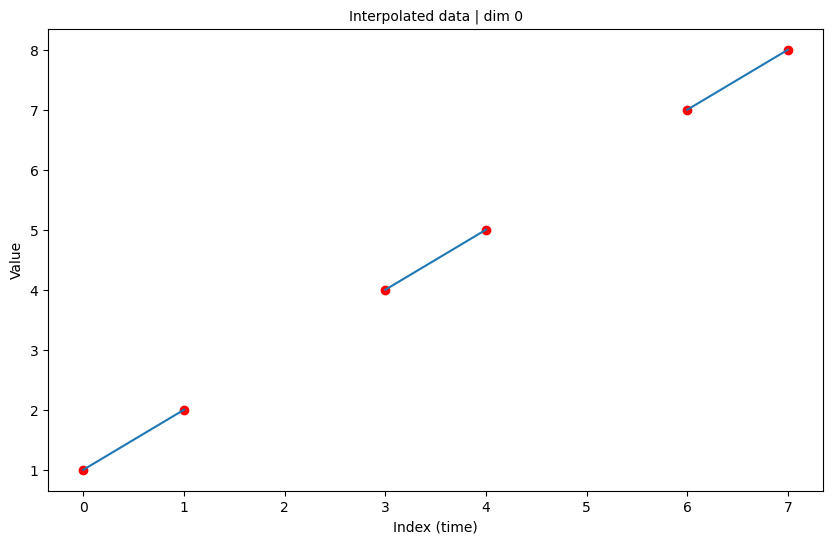

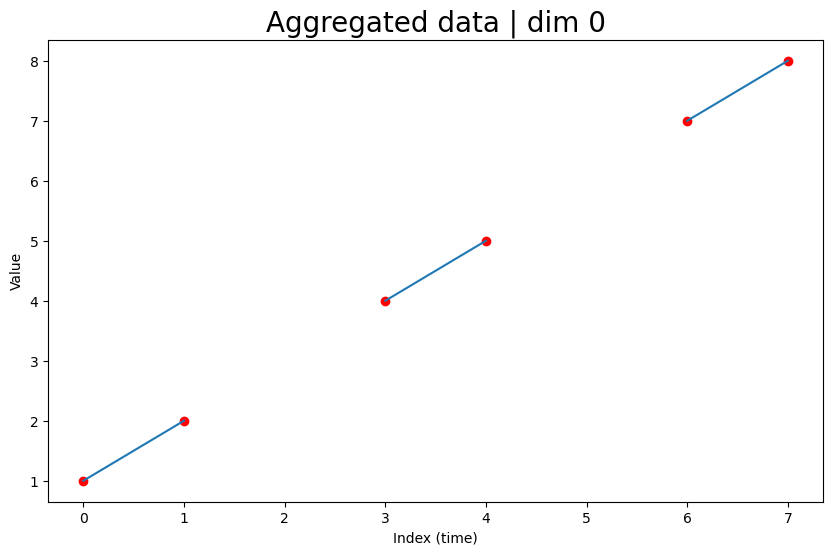

Downsample | ts_paa~9
Downsample ------------------------>


In [28]:
#| hide
foo_data = np.array([1.0, 2.0, np.nan, 4.0, 5.0, np.nan, 7.0, 8.0])
foo_data_2 = downsample(foo_data, max_points = 10, verbose = 2, show_plots = True)